In [3]:
import json
import numpy as np
import os
import locale
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler

# Data Source
import yfinance as yf
import matplotlib.pyplot as plt

from stock_modules.stock_io import (read_tickers_from_excel,
                                    get_histories)

# Figures
from stock_modules.stock_plot import plot_numpy_arr_cols
if not os.path.exists("./figures"):
    os.mkdir("./figures")

# test GPU found
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [6]:
ENCODING = locale.getpreferredencoding()
DF_PATH = "HEL_12-10-21to08-11-23.csv"
HISTORY_ARRAY_PATH = "./histories_arr.npy"
MODEL_PATH = "./keras-tuner-dir"
SELECTED_TICKERS_PATH = "./TICKERS_TO_FOLLOW.json"
SELECTED_TICKERS = json.load(open(SELECTED_TICKERS_PATH, "r", encoding=ENCODING))
DATAFRAME = pd.read_csv(DF_PATH, encoding=ENCODING)
DATAFRAME.set_index("date", inplace=True)
HAS_TIMEDELTA = "Time Delta" in DATAFRAME.columns
# ind transformation tells the label of each index in the np_arr_test
IND_CONVERSION = {i: ticker for i, ticker in enumerate(DATAFRAME.columns) if ticker in SELECTED_TICKERS}
IND_CONVERSION = {i: ticker for i, ticker in enumerate(IND_CONVERSION.values())}
print("Selected tickers: \n", SELECTED_TICKERS)
print("Dataframe shape: ", DATAFRAME.shape)
print(f"Index conversion: \n")
for k, v in IND_CONVERSION.items():
    print(f"{k}: {v}")
print(f"Using Time Delta: {HAS_TIMEDELTA}")
    

Selected tickers: 
 ['ALBBV.HE', 'CGCBV.HE', 'EQV1V.HE', 'KNEBV.HE', 'ORNBV.HE', 'OLVAS.HE', 'DETEC.HE', 'PON1V.HE', 'ORNAV.HE', 'VALMT.HE', 'NESTE.HE', 'HUH1V.HE', 'REG1V.HE', 'VAIAS.HE']
Dataframe shape:  (4389, 14)
Index conversion: 

0: REG1V.HE
1: NESTE.HE
2: ORNBV.HE
3: KNEBV.HE
4: OLVAS.HE
5: HUH1V.HE
6: DETEC.HE
7: ORNAV.HE
8: CGCBV.HE
9: VAIAS.HE
10: ALBBV.HE
11: VALMT.HE
12: EQV1V.HE
13: PON1V.HE
Using Time Delta: False


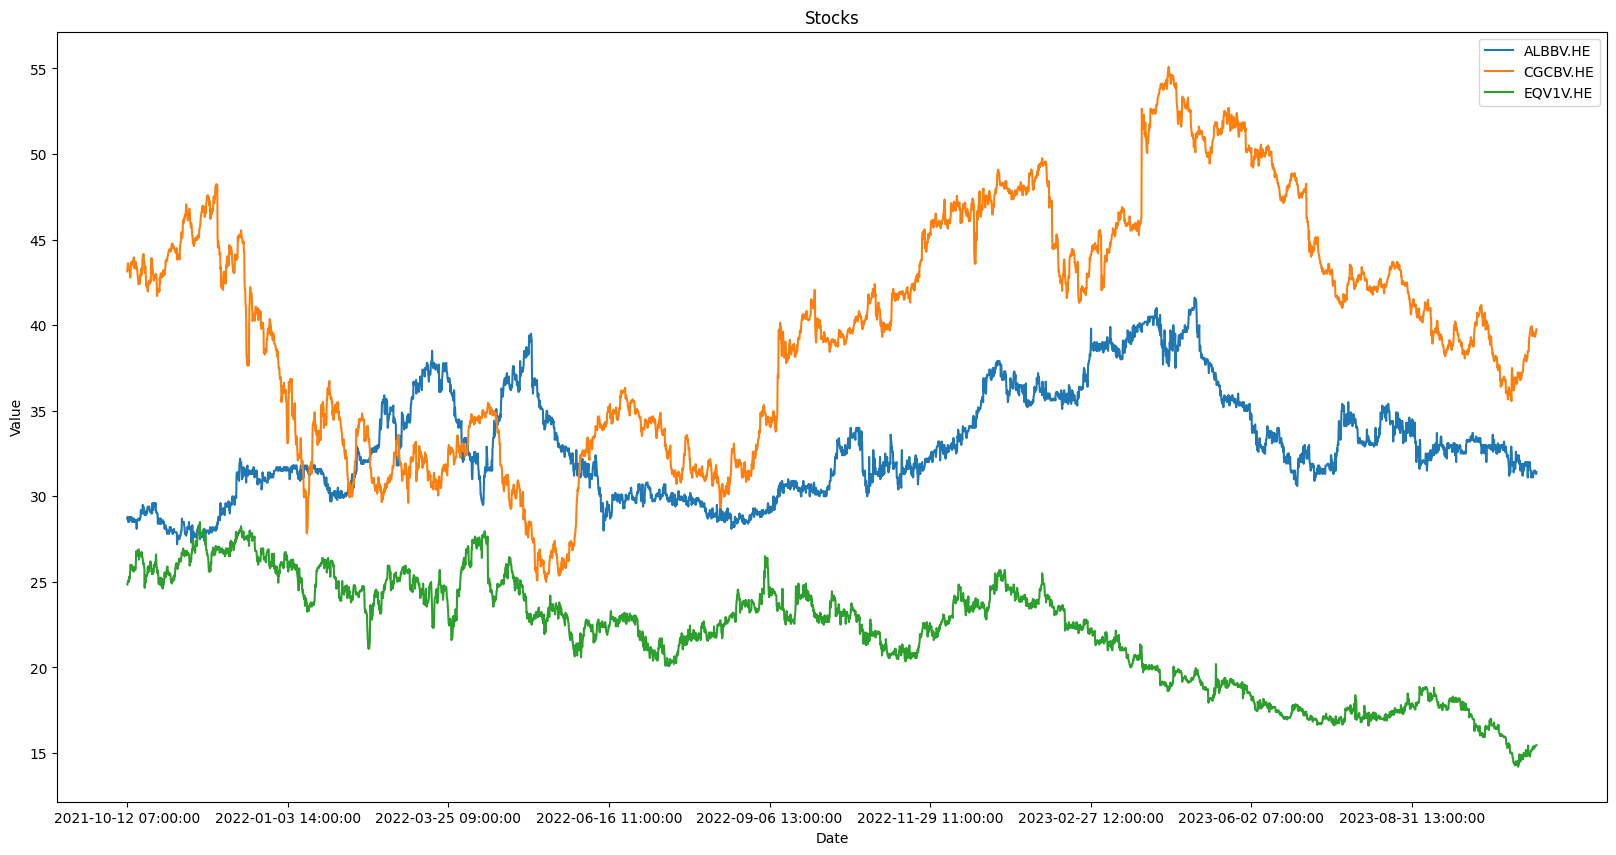

In [3]:
# Show values or not
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title("Stocks")
ax.set_xlabel("Date")
ax.set_ylabel("Value")
for ticker in SELECTED_TICKERS[:3]:
    ax.plot(DATAFRAME.index, DATAFRAME[ticker], label=ticker)
# Change xticks
ax.set_xticks(DATAFRAME.index[::500])
ax.legend()
plt.show()

In [7]:
# If we are predicting the next price, we just minmax scale the data
TEST_FRAC = 0.2

df = DATAFRAME.copy()
if HAS_TIMEDELTA:
    td_col = df["Time Delta"]
    df.drop("Time Delta", axis=1, inplace=True)
diff_df = df.diff()
# The first row is NaN, so lets copy the second row there
diff_df.iloc[0, :] = diff_df.iloc[1, :]
# Add back the Time Delta column
if HAS_TIMEDELTA:
    diff_df["Time Delta"] = td_col
    # Make Time Delta the first column
    cols = diff_df.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    diff_df = diff_df[cols]
transformed_df = diff_df

# Now the transformed_df contains the data that is input to the model
# The original price data is in DATAFRAME
print(f"Dataframe shape: {df.shape}")
print(f"Transformed df shape: {transformed_df.shape}")


Dataframe shape: (4389, 14)
Transformed df shape: (4389, 14)


In [41]:
# Reload modules
%load_ext autoreload
%autoreload 2

from stock_modules.stock_transform import create_batch_xy
MHOURS = 24
OUTPUT_SCALE = (0,1)
CHANGE_THRESHOLD = 0.002
def update_global_mhours(new_mhours):
    global MHOURS, X_train, Y_train, X_test, Y_test, X_og, Y_og
    MHOURS = new_mhours
    print(f"MHOURS is now {MHOURS}")
    print(f"Recalculating X and Y data...")
    # Batch X data into sequences of length MHOURS (from T to T+n)
    # Label Y data as 0, 1, 2 for down, flat, up
    # We give the data in the original format, so that the labels can be calculated
    _, Y = create_batch_xy(MHOURS,
                        DATAFRAME,
                        overlap=True,
                        y_updown=False,
                        y_direction=True,
                        threshold=CHANGE_THRESHOLD,
                        to_onehot=True,
                        create_labels=True,
                        )

    # Here instead, we can give the differenced data, because we don't need to calculate the labels
    X,_ = create_batch_xy(MHOURS,
                            transformed_df,
                            overlap=True,
                            create_labels=False,
                            )

    # Swap 2nd and 3rd axes in Y to reshape it to (n_samples, 3,nstocks)
    Y = np.swapaxes(Y, 1, 2)

    X_og = X.copy()
    Y_og = Y.copy()

    print(f"X shape: {X.shape}")
    print(f"Y shape: {Y.shape}")

    test_sz = int(X.shape[0] * TEST_FRAC)

    # Split the data into train and test sets
    X_train = X[:-test_sz,:,:]
    Y_train = Y[:-test_sz,:,:]
    X_test = X[-test_sz:,:,:]
    Y_test = Y[-test_sz:,:,:]

update_global_mhours(MHOURS)

print(f"One input shape: {X_train[0].shape}")
print(f"One output shape: {Y_train[0].shape}")

print(f"Example input: \n {X_train[0]}")
print(f"Example output: \n {Y_train[0]}")

# Count the number of ups/downs/flats in Y_train
print(f"Y_train: {Y_train}")
print(f"Number of down classes: {np.sum(Y_train[:,0,:])}")
print(f"Number of flat classes: {np.sum(Y_train[:,1,:])}")
print(f"Number of up classes: {np.sum(Y_train[:,2,:])}")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
MHOURS is now 24
Recalculating X and Y data...
[[55.95000076 41.81999969 35.68999863 ... 36.45999908 24.85000038
  39.15000153]
 [55.79999924 41.72000122 35.63000107 ... 36.59999847 24.95000076
  39.20000076]
 [55.70000076 42.06000137 35.40000153 ... 36.40000153 25.
  39.5       ]
 ...
 [22.81999969 31.82999992 36.90999985 ... 22.60000038 15.43999958
  24.        ]
 [22.89999962 31.84000015 37.13000107 ... 22.65999985 15.46000004
  23.70000076]
 [23.02000046 31.89999962 37.18999863 ... 22.78000069 15.46000004
  24.04999924]]

            Batched 'histories_arr' ((4389, 14)) to 'X'
            ((4365, 24, 14)) and 'Y' ((4365, 14, 3))
            
[[-0.15000153 -0.09999847 -0.05999756 ...  0.13999939  0.10000038
   0.04999924]
 [-0.15000153 -0.09999847 -0.05999756 ...  0.13999939  0.10000038
   0.04999924]
 [-0.09999847  0.34000015 -0.22999954 ... -0.19999695  0.04999924
   0.29999924]
 ...
 [-0.04000

In [42]:
class SkipTDLoss(tf.keras.losses.Loss):
    """ A loss funciton, that calculates the given loss but ignores the first column from y_true and y_pred.
    """
    def __init__(self, base_loss_fun, **kwargs):
        super().__init__(**kwargs)
        self.base_loss_fun = base_loss_fun
    
    def call(self, y_true, y_pred):
        # Skip first column
        return self.base_loss_fun(y_true[:,1:], y_pred[:,1:])
    
class MultiSoftmaxLoss(tf.keras.losses.Loss):
    """ Calculates the mean categorical crossentropy loss for each stock prediction.
    So input is (batch_size, nhours, nstocks), and output is (batch_size, 3, nstocks)
    The CCE/log loss is calculated for each stock and then averaged.
    """
    def __init__(self):
        super().__init__()
        self.loss_fun = tf.keras.losses.CategoricalCrossentropy()
    
    def call(self, y_true, y_pred):
        pred_losses = []
        # Calculate the softmax loss for each one-hot prediction
        # Y data is (3, nstocks), so take one column at a time, compare it to the true value and calculate the loss
        for i in range(y_true.shape[2]):
            y_pred_i = y_pred[:,:,i]
            y_true_i = y_true[:,:,i]
            #print(f"Comparing y_true_i shape: {y_true_i.shape} to y_pred_i shape: {y_pred_i.shape}")
            pred_losses.append(self.loss_fun(y_true_i, y_pred_i))
        # Now we have a list of losses for each stock, so we can calculate the mean
        pred_losses = tf.stack(pred_losses, axis=0)
        mean_loss = tf.reduce_mean(pred_losses, axis=0)
        return mean_loss
    
class MultiAccuracy(tf.keras.metrics.Metric):
    """ Calculates the average prediction accuracy for the predictions.
    So for stock, we calculate the accuracy of the prediction, sum them and then divide by the number of stocks.
    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.accuracy = tf.keras.metrics.CategoricalAccuracy()
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        # Calculate the accuracy for each stock
        accs = []
        for i in range(y_true.shape[2]):
            y_true_i = y_true[:,:,i]
            y_pred_i = y_pred[:,:,i]
            # y_pred_i to onehot
            y_pred_i = tf.one_hot(tf.argmax(y_pred_i, axis=1), depth=3)
            accs.append(self.accuracy(y_true_i, y_pred_i))
        # Now we have a list of accuracies for each stock, so we can calculate the mean
        accs = tf.stack(accs, axis=0)
        mean_acc = tf.reduce_mean(accs, axis=0)
        self.mean_acc = mean_acc
    
    def result(self):
        return self.mean_acc
    
    def reset_states(self):
        pass

    
    
    
LOSS_FUN = MultiSoftmaxLoss()

In [43]:
# Tune the hyperparameters
import keras_tuner as kt
def get_direction_pred_model(hp):
    """ Returns a model that predicts the direction of the stock price.
    """
    
    # Input shape is (nhours, nstocks)
    input_shape = (MHOURS, X_train.shape[2])
    # Output shape is (3, nstocks)
    output_shape = (3, Y_train.shape[2])
    
    inputs = tf.keras.layers.Input(shape=input_shape)
    
    nlstm_layers = hp.Int("nlstm_layers", min_value=1, max_value=3, step=1)
    lstm_units = hp.Int("lstm_units", min_value=32, max_value=128, step=32)
    # Add LSTM layers
    x = inputs
    for i in range(nlstm_layers):
        x = tf.keras.layers.LSTM(lstm_units, return_sequences=True)(x)
    
    # Flatten the output
    ndense_layers = hp.Int("ndense_layers", min_value=1, max_value=3, step=1)
    dense_units = hp.Int("dense_units", min_value=32, max_value=128, step=32)
    dropout_rate = hp.Float("dropout_rate", min_value=0.1, max_value=0.5, step=0.1)
    x = tf.keras.layers.Flatten()(x)
    for i in range(ndense_layers):
        x = tf.keras.layers.Dense(dense_units, activation="relu")(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)
    # Output layer
    outputs = tf.keras.layers.Dense(output_shape[0]*output_shape[1], activation="linear")(x)
    outputs = tf.keras.layers.Reshape(output_shape)(outputs)
    # apply aoftmax to the columns
    outputs = tf.keras.layers.Softmax(axis = 1)(outputs)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    use_amsgrad = hp.Boolean("use_amsgrad")
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(amsgrad=use_amsgrad),
                  loss=LOSS_FUN,
                  metrics=[MultiAccuracy()])
    return model

# Create a tuner
tuner = kt.Hyperband(get_direction_pred_model,
                     objective="val_loss",
                     max_epochs=200,
                     factor=10,
                     directory=MODEL_PATH,
                     project_name="direction_prediction")

# Create a callback to stop training early
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience=10,
                                                  restore_best_weights=True)

# Train the model
tuner.search(X_train,
             Y_train,
             epochs=200,
             validation_split=0.2,
             callbacks=[early_stopping])

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()
# save the model
best_model.save("model.h5")

# Evaluate the model
loss, acc = best_model.evaluate(X_test, Y_test)
print(f"Test loss: {loss}, test accuracy: {acc}")





SyntaxError: invalid syntax. Perhaps you forgot a comma? (3178211402.py, line 47)

In [37]:
%load_ext autoreload
%autoreload 2
#from stock_modules.stock_ml import create_direction_prediction_model

MODEL_PATH = "./model.h5"
RENEW_MODEL = False
PATIENCE = 20
EPOCHS = 200
BATCH_SIZE = 128

# Fit model by showing it the data from the last MHOURS hours, and
# predicting the next hour
if os.path.exists(MODEL_PATH) and not RENEW_MODEL:
    if HAS_TIMEDELTA:
        skip_td_loss = SkipTDLoss(LOSS_FUN)
        model = tf.keras.models.load_model(MODEL_PATH, custom_objects={"SkipTDLoss": skip_td_loss, "MultiAccuracy": MultiAccuracy()})
    else:
        model = tf.keras.models.load_model(MODEL_PATH, custom_objects={"MultiAccuracy": MultiAccuracy()})
else:
    # The model takes in (batch_size, MHOURS, nstocks) and outputs (batch_size, 3, nstocks)
    # If HAS_TIMEDELTA, the model still outputs a value for the timedelta column, but we ignore it in the loss function
    model = create_direction_prediction_model(MHOURS, DATAFRAME.shape[1])
    print(model.summary())
    # Show example output of model
    test_pred = np.array(model.predict(X_train[0:1,:,:]))
    print(f"Example model output for single stock: \n {test_pred}")
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss=LOSS_FUN, optimizer=opt, metrics=[MultiAccuracy()])
    if HAS_TIMEDELTA:
        model.compile(loss=SkipTDLoss(LOSS_FUN), optimizer="adam", metrics=[MultiAccuracy()])
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=PATIENCE,
        restore_best_weights=True
    )
    print(f"Starting training for {EPOCHS} epochs, with batch size {BATCH_SIZE} and data shapes {X_train.shape} and {Y_train.shape}")
    model.fit(X_train, Y_train,
            epochs=EPOCHS, batch_size=BATCH_SIZE,
            validation_data=(X_test, Y_test), verbose=1,
            callbacks=[early_stop], shuffle=True)
    model.save(MODEL_PATH)
# Show true values and predictions
Y_pred = model.predict(X_test)
if HAS_TIMEDELTA:
    Y_pred = Y_pred[:,1:]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Model: "model_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 24, 14)]          0         
                                                                 
 batch_normalization_25 (Ba  (None, 24, 14)            56        
 tchNormalization)                                               
                                                                 
 lstm_50 (LSTM)              (None, 24, 64)            20224     
                                                                 
 lstm_51 (LSTM)              (None, 24, 16)            5184      
                                                                 
 flatten_25 (Flatten)        (None, 384)               0         
                                                                 
 dense_50 (Dense)            (None, 

/home/ilmari/python/stonk-prediction/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:2620: UserWarning: Metric MultiAccuracy implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


Comparing y_true_i shape: (None, 3) to y_pred_i shape: (None, 3)
Comparing y_true_i shape: (None, 3) to y_pred_i shape: (None, 3)
Comparing y_true_i shape: (None, 3) to y_pred_i shape: (None, 3)
Comparing y_true_i shape: (None, 3) to y_pred_i shape: (None, 3)
Comparing y_true_i shape: (None, 3) to y_pred_i shape: (None, 3)
Comparing y_true_i shape: (None, 3) to y_pred_i shape: (None, 3)
Comparing y_true_i shape: (None, 3) to y_pred_i shape: (None, 3)
Comparing y_true_i shape: (None, 3) to y_pred_i shape: (None, 3)
Comparing y_true_i shape: (None, 3) to y_pred_i shape: (None, 3)
Comparing y_true_i shape: (None, 3) to y_pred_i shape: (None, 3)
Comparing y_true_i shape: (None, 3) to y_pred_i shape: (None, 3)
Comparing y_true_i shape: (None, 3) to y_pred_i shape: (None, 3)
Comparing y_true_i shape: (None, 3) to y_pred_i shape: (None, 3)
Comparing y_true_i shape: (None, 3) to y_pred_i shape: (None, 3)
28/28 [==============================] - 5s 67ms/step - loss: 1.0970 - multi_accuracy_21: 

/home/ilmari/python/stonk-prediction/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 0s 2ms/step


In [38]:
print("Y_pred: \n", Y_pred)
print("Y_test: \n", Y_test)

# Calculate the accuracy of up-down-flat predictions
# So predict the up/down of each stock, at each time on the test data (Y_pred)
# and compare it to the true values (Y_test)
for stock_idx in range(Y_pred.shape[2] -1 if HAS_TIMEDELTA else Y_pred.shape[2]):
    # Get the up/down/flat predictions for the stock
    direction_preds = Y_pred[:,:,stock_idx]
    #print(f"direction_preds: \n {direction_preds}")
    # Get the true up/down/flat values for the stock
    direction_true = Y_test[:,:,stock_idx]
    # Get the predicted up/down/flat class
    direction_preds = np.argmax(direction_preds, axis=1)
    # Get the true up/down/flat class
    direction_true = np.argmax(direction_true, axis=1)
    # Calculate the accuracy
    accuracy = np.sum(direction_preds == direction_true) / len(direction_preds)
    print(f"Up/Down/Flat accuracy for stock {IND_CONVERSION[stock_idx]}: {accuracy}")


Y_pred: 
 [[[0.3330458  0.3551339  0.26505473 ... 0.2859853  0.35863417 0.32500416]
  [0.33144635 0.32243302 0.45690554 ... 0.42802945 0.254924   0.32500416]
  [0.3355078  0.32243302 0.27803972 ... 0.2859853  0.3864418  0.34999165]]

 [[0.33271435 0.3550569  0.26761165 ... 0.28677696 0.35451922 0.32348913]
  [0.33271435 0.3224716  0.4556406  ... 0.42644602 0.25553158 0.32348913]
  [0.33457127 0.3224716  0.27674773 ... 0.28677696 0.38994917 0.35302174]]

 [[0.3317925  0.36426798 0.27247694 ... 0.28940836 0.36497685 0.3251238 ]
  [0.3317925  0.31786603 0.44933662 ... 0.42118317 0.2579574  0.3251238 ]
  [0.33641502 0.31786603 0.27818647 ... 0.28940836 0.37706575 0.34975237]]

 ...

 [[0.33333334 0.341445   0.261053   ... 0.27938294 0.38372746 0.33054543]
  [0.33333334 0.32927752 0.45831403 ... 0.4412342  0.25502357 0.33054543]
  [0.33333334 0.32927752 0.280633   ... 0.27938294 0.36124888 0.33890915]]

 [[0.33333334 0.33751363 0.25815165 ... 0.2769247  0.38316575 0.33052084]
  [0.33333334 

In [39]:

from invest_strategies import (calculate_optimal_invest_strategy,
                               calculate_profit_on_invest_strategy,
                               strategy_mask_from_price_model,
                               strategy_mask_from_updown_model,
                               strategy_mask_from_direction_model)

# Calculate profit by optimal strategy (theoretical) vs using model to predict
test_sz = int(DATAFRAME.shape[0] * TEST_FRAC)
df_test = DATAFRAME.iloc[-test_sz:,:].copy()
if HAS_TIMEDELTA:
    df_test.drop("Time Delta", axis=1, inplace=True)
np_arr_test = df_test.to_numpy()
print("np_arr_test data shape: ", np_arr_test.shape)

optimal_trading_mask = calculate_optimal_invest_strategy(np_arr_test)
print(f"Optimal mask 4th stock: \n {optimal_trading_mask[:,2]}")
profit_optimal = calculate_profit_on_invest_strategy(np_arr_test, optimal_trading_mask)
print(f"Optimal strategy matrix shape: {optimal_trading_mask.shape}")
print(f"Profit by optimal strategy on test data: {profit_optimal}")

# To calculate the mask for the model, we need to give the data in the same format as it was trained in
transformed_df_test = transformed_df.iloc[-test_sz:,:]
transformed_np_arr_test = transformed_df_test.to_numpy()
print("transformed_np_arr_test data shape: ", transformed_np_arr_test.shape)
print(transformed_np_arr_test[0:2,:])
prediction_trading_mask = strategy_mask_from_direction_model(transformed_np_arr_test, MHOURS, model)

if HAS_TIMEDELTA:
    prediction_trading_mask = prediction_trading_mask[:,1:]

print(f"Prediction mask 2nd stock: \n {prediction_trading_mask[:,2]}")
if HAS_TIMEDELTA:
    profit_pred_model = calculate_profit_on_invest_strategy(np_arr_test[:,1:], prediction_trading_mask)
else:
    profit_pred_model = calculate_profit_on_invest_strategy(np_arr_test, prediction_trading_mask)
print(f"Prediction strategy matrix shape: {prediction_trading_mask.shape}")
print(f"Profit by predicting the next hour using the model: {profit_pred_model}")

np_arr_test data shape:  (877, 14)
Optimal mask 4th stock: 
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0

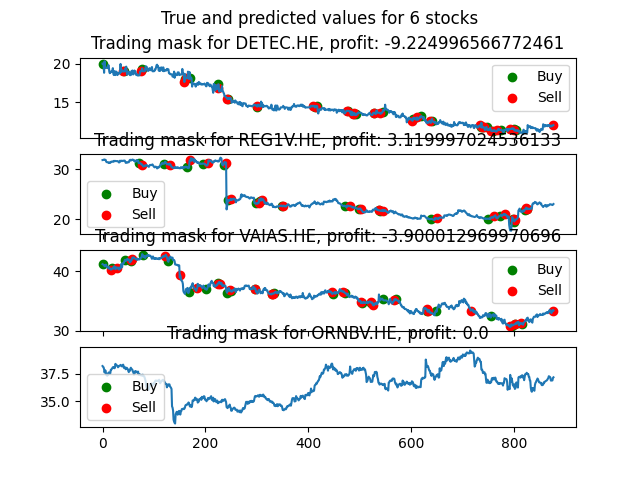

(<Figure size 640x480 with 4 Axes>,
 array([<Axes: title={'center': 'Trading mask for DETEC.HE, profit: -9.224996566772461'}>,
        <Axes: title={'center': 'Trading mask for REG1V.HE, profit: 3.119997024536133'}>,
        <Axes: title={'center': 'Trading mask for VAIAS.HE, profit: -3.900012969970696'}>,
        <Axes: title={'center': 'Trading mask for ORNBV.HE, profit: 0.0'}>],
       dtype=object))

In [40]:
%matplotlib widget
from stock_modules.stock_plot import plot_strategy_based_on_predictions,plot_mask_and_data
stock_indices = np.random.choice(np.arange(len(IND_CONVERSION)), 4, replace=False)
part_mask = prediction_trading_mask[:,stock_indices]

if HAS_TIMEDELTA:
    part_price = np_arr_test[:,1:][:,stock_indices]
else:
    part_price = np_arr_test[:,stock_indices]
ind_conversion = {si : IND_CONVERSION[i] for si, i in enumerate(stock_indices)}
plot_mask_and_data(part_mask, part_price, ind_conversion)